In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

print("Path to dataset files:", path)

100%|██████████| 82.0M/82.0M [00:00<00:00, 98.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2


In [ ]:
#IMPORTS
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
print("Dataset path:", path)
print("Files:", os.listdir(path))


Dataset path: /root/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2
Files: ['garbage classification', 'Garbage classification', 'one-indexed-files-notrash_val.txt', 'one-indexed-files-notrash_train.txt', 'zero-indexed-files.txt', 'one-indexed-files.txt', 'one-indexed-files-notrash_test.txt']


In [ ]:
dataset_path = os.path.join(path, "Garbage classification", "Garbage classification")
print(os.listdir(dataset_path))

['cardboard', 'metal', 'trash', 'plastic', 'glass', 'paper']


In [ ]:
#Loading and Pre Processing the data
img_size = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

# Train and validation data generators
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:
# ✅ STEP 3: CLASS WEIGHTS (To handle imbalance)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.04437564499484), 1: np.float64(0.8412302576891105), 2: np.float64(1.0284552845528456), 3: np.float64(0.7086834733893558), 4: np.float64(0.8739205526770294), 5: np.float64(3.066666666666667)}


In [ ]:
# ✅ STEP 4: BUILD MODEL (TRANSFER LEARNING with MobileNetV2)
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/tmp/ipython-input-7-197592734.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# ✅ STEP 5: TRAIN INITIAL MODEL
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.6921 - loss: 0.8086 - val_accuracy: 0.5885 - val_loss: 1.1276
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step - accuracy: 0.7101 - loss: 0.7795 - val_accuracy: 0.5944 - val_loss: 1.1219
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.7244 - loss: 0.7731 - val_accuracy: 0.5805 - val_loss: 1.1081
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.7607 - loss: 0.6976 - val_accuracy: 0.6163 - val_loss: 1.0710
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.7612 - loss: 0.6948 - val_accuracy: 0.6004 - val_loss: 1.0735
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.7858 - loss: 0.6417 - val_accuracy: 0.6561 - val_loss: 1.0002
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.7865 - loss: 0.6218 - val_accuracy: 0.6342 - val_loss: 1.0261
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.7951 - loss: 0.5642 - val_accu

In [12]:
# ✅ STEP 6: UNFREEZE AND FINE-TUNE
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 476ms/step - accuracy: 0.8129 - loss: 0.4879 - val_accuracy: 0.6740 - val_loss: 0.9461
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.8237 - loss: 0.4944 - val_accuracy: 0.6720 - val_loss: 0.9151
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.8571 - loss: 0.4351 - val_accuracy: 0.6680 - val_loss: 0.9179
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.8462 - loss: 0.4347 - val_accuracy: 0.6899 - val_loss: 0.8774
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.8585 - loss: 0.4154 - val_accuracy: 0.7177 - val_loss: 0.8432
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.8629 - loss: 0.3878 - val_accuracy: 0.6899 - val_loss: 0.8692
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.8499 - loss: 0.3979 - val_accuracy: 0.7097 - val_loss: 0.8429
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.8787 - loss: 0.3477 - val_accu

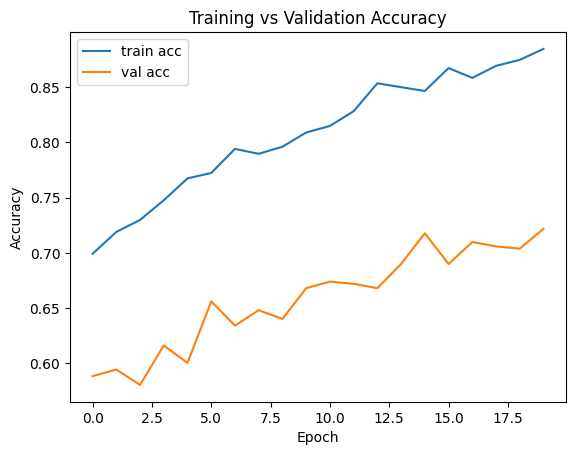

In [13]:
# ✅ STEP 7: PLOT RESULTS
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='val acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# ✅ STEP 8: CLASSIFICATION REPORT
from sklearn.metrics import classification_report
val_data.reset()
y_pred = np.argmax(model.predict(val_data), axis=1)
y_true = val_data.classes

class_labels = list(train_data.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step
              precision    recall  f1-score   support

   cardboard       0.92      0.68      0.78        80
       glass       0.69      0.75      0.72       100
       metal       0.68      0.76      0.72        82
       paper       0.88      0.82      0.85       118
     plastic       0.64      0.70      0.67        96
       trash       0.48      0.52      0.50        27

    accuracy                           0.73       503
   macro avg       0.71      0.70      0.70       503
weighted avg       0.75      0.73      0.74       503



In [15]:
loss, accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {accuracy*100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.7384 - loss: 0.8779
Validation Accuracy: 72.96%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


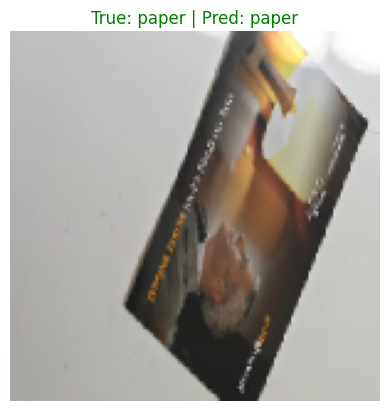

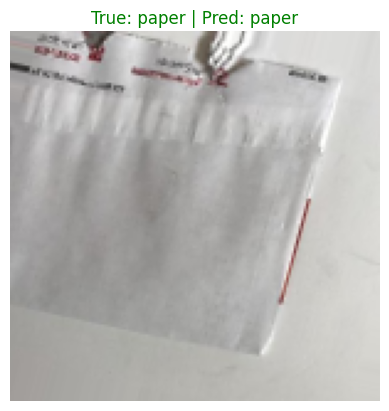

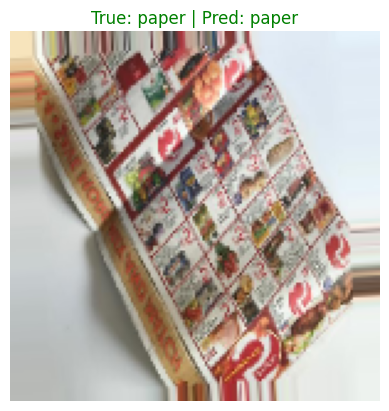

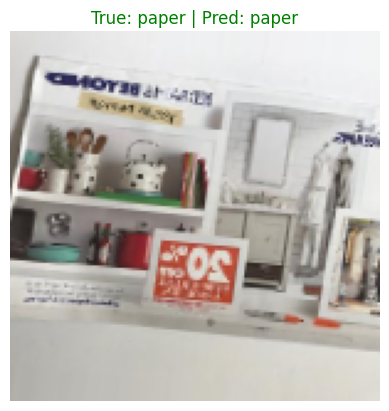

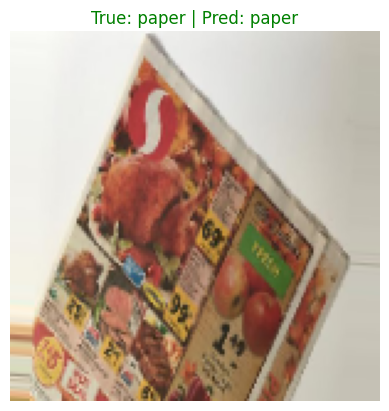

In [27]:
class_names = list(train_data.class_indices.keys())  # Get folder/class names

# Get a batch of validation images
images, labels = next(val_data)

# Predict
predictions = model.predict(images)

# Plot first 5 predictions
for i in range(5):
    plt.imshow(images[i])
    plt.axis('off')
    true_label = class_names[np.argmax(labels[i])]
    predicted_label = class_names[np.argmax(predictions[i])]
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"True: {true_label} | Pred: {predicted_label}", color=color)
    plt.show()
